In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt, mpld3
import os
import fnmatch
import csv
import pickle
import warnings
import torch
import time

warnings.filterwarnings('ignore')

### Required for building NN ###
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from termcolor import colored
import tensorflow.keras.backend as K

## Load and prepare data

### Raw data

The training data consists of the following sets: 
- 200 keV, 100 ms
- 200 keV, 10 ms
- 60 keV, 100 ms
- 60 keV, 10 ms

1) Import all data points from text files using Pandas

2) Apply a window: the raw spectra are calibrated with their peak around 0 eV loss, but the length of each spectrum differs. Therefore, a window is applied to the input data: it selects the data of all input spectra between [-0.2, 0.5] eV loss 

3) Use 'sklearn.train_test_split' to split the data into training and validation points




<Figure size 432x288 with 0 Axes>

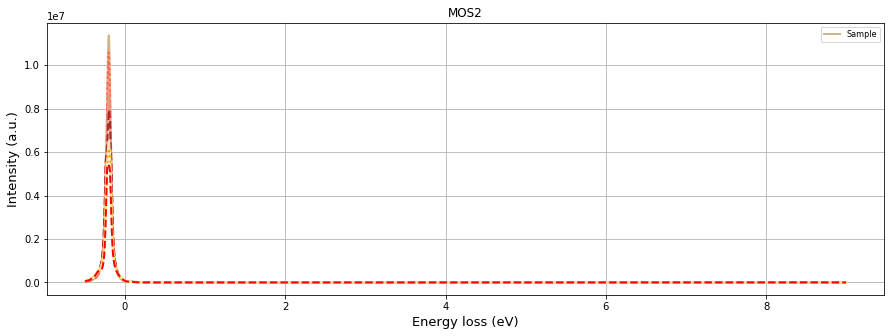

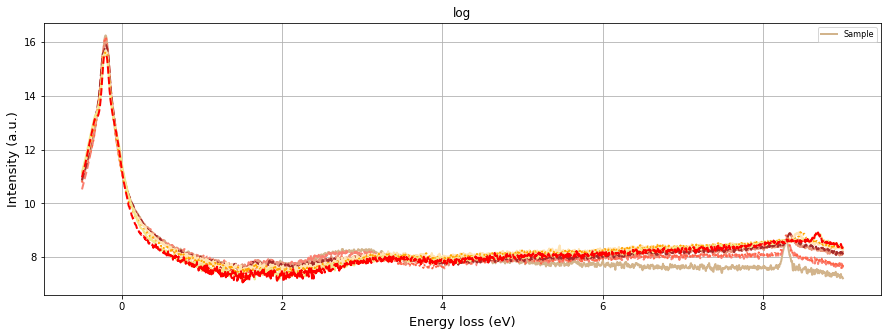

In [50]:
%run EELS-ZLP-May.py

## Data preprocessing

Unscaled input variables can result in a slow or unstable learning process, whereas unscaled target variables on regression problems can result in exploding gradients causing the learning process to fail. [1]

The energy loss is scaled between [-1, 1] and all input spectra are scaled between [0.1, 0.9]. 

### Binning
The discretization technique used to assign mean and standard deviation the data points is called Equal Width Discretization [2]. EWD is a simple discretization method that divides the range of observed values for a feature into k equal sized bins. The intervals are computed by 
 $\Delta E = (E_{max} - E_{min}) / k$. \
 Then, within each energy bin $\Delta E$, the mean and variance of all data points within this bin are determined and returned to the original data points. This way, each data point is a vector $[dE, D_i, \sigma_i]$ where dE is the original energy loss; $D_i$ and $\sigma_i$ are the mean and std of the bin $i$ where this point belongs to.  Note that the number of data points within each bin is not necessarily the same. The minimum and maximum number of data points within each bin can be found in the output.

[1] https://github.com/juanrojochacon/ml-ditp-attp/blob/master/Tutorials/Tutorial2/notebooks/Tutorial2a-NonLinearRegression-GLUON.ipynb

[2] (PDF) Comparative Analysis of Supervised and Unsupervised Discretization Techniques. Available from: https://www.researchgate.net/publication/266058863_Comparative_Analysis_of_Supervised_and_Unsupervised_Discretization_Techniques [accessed Apr 16 2020].


With 200 bins, the minimum number of training points within each bin is 9 and maximum is 10


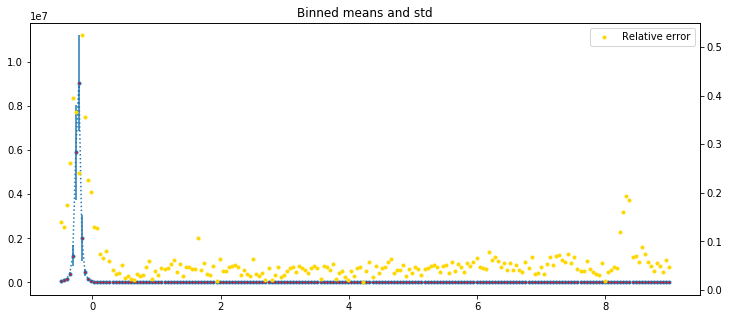

In [51]:
%run Functions.ipynb
fig = plt.gcf()

x_train = x1
y_train = y1

nbins = 200
minval = min(x_train)
maxval = max(x_train)

# Store output vectors for training
df_train, cuts1_t, cuts2_t = ewd(x_train, y_train)
mean_t, std_t, count_t= binned_statistics(x_train, y_train)
variance_vector_t = vectorize_variance(x_train, y_train)
mean_vector_t = vectorize_mean(x_train, y_train)
# create one vector with (x_train, y_train, sigma_train)
print("With", nbins, "bins, the minimum number of training points within each bin is", int(min(count_t)), "and maximum is", int(max(count_t)))

# Create a plot of the mean & std 
plot_uncertainties(x_train, y_train, nbins, minval, maxval)
ax2 = plt.twinx()
ax2.plot(np.linspace(minval, maxval, nbins), np.divide(std_t, mean_t), '.', color='gold',  label='Relative error')
#ax2.plot_uncertainties(x_train, y_train, nbins, minval, maxval)
plt.legend()
fig.set_size_inches(12, 5)
plt.show()


In [80]:
df = pd.DataFrame()

df['x'] = x_train + 0.2025 # shift to align peak with zero loss
df['y'] = y_train
df['sigma'] = variance_vector_t

df.head()

,x,y,sigma
0,-0.295,51009.4,9224.256931
1,-0.290,53958.4,9224.256931
2,-0.285,57218.7,9224.256931
3,-0.280,60768.2,9224.256931
4,-0.275,64236.4,9224.256931


In [81]:
## FWHM is 0.03 eV loss. Window around 3 times FWHM. 

FWHM = max(df[df['y'] > .5 * max(df['y'])]['x'])
df_window = df[np.abs(df['x']) <= 3 * FWHM]

## Closure testing

In order to test if the computed error associated to each training point is reasonable, a method called Closure Testing can provide insight.  The 'true' values are then the best Gaussian fit sampled at the energy data of the training points. The parameters of the best fit are determined in the notebook *Gaussian.ipynb* and are fitted to the original data points (before binning).

In [ ]:
#%run Gaussian.ipynb

#y_gaus = gaussian(df_train[:,0], amp10, cen10, std10 )

#plt.plot(df_train[:,0], y_gaus, 'o')

### Merge all data for training

In [24]:
Npoints = 1000
train_pseudox10 = np.zeros(shape=(Npoints, 3))
train_pseudox100 = np.zeros(shape=(Npoints, 3))
train_pseudoy = .100 * np.ones(shape=(Npoints*2, 1))
train_pseudosigma = .003 * np.ones(shape=(Npoints*2, 1))

time_1 = .1 * np.ones(1000)
time_2 = np.ones(1000)
train_pseudox10[:,1]  = time_1
train_pseudox100[:, 1] = time_2

pseudodata_beam = np.linspace(0, 4, 100)

for i in range(10):
    train_pseudox10[100*i:100*(i+1),0] = np.linspace(-1, -0.75, 100)
    train_pseudox100[100*i:100*(i+1),0] = np.linspace(-1, -0.75, 100)
    train_pseudox10[100*i:100*(i+2),2] = (i+1) * 0.3
    train_pseudox100[100*i:100*(i+2),2] = (i+1) * 0.3

train_pseudo = np.vstack([train_pseudox10, train_pseudox100])
train_pseudo_x = np.c_[train_pseudo, train_pseudoy, train_pseudosigma]

print(train_pseudo_x.shape)

#p.savetxt('Data/May/Pseudo_trainingsdata_x.csv', train_pseudo_x, delimiter=",", header="x, time, energy, y")
#np.savetxt('Data/May/Pseudo_trainingsdata_y.csv', train_pseudoy)

(2000, 5)


In [22]:
f1 = pd.read_csv('Data/May/100ms60keV_nbins=200.csv', header=None)
f1['time'] = 1
f1['energy'] = .6
f2 = pd.read_csv('Data/May/100ms200keV_nbins=180.csv', header=None)
f2['time'] = 1
f2['energy'] = 2
f3 = pd.read_csv('Data/May/10ms200keV_nbins=600.csv', header=None)
f3['time'] = .1
f3['energy'] = 2
f4 = pd.read_csv('Data/May/10ms60keV_nbins=200.csv', header=None)
f4['time'] = .1
f4['energy'] = .6
frames = f1.append(f2).append(f3).append(f4)

frames.drop_duplicates(subset=None, inplace=True)

#frames.to_csv('Data/May/training_merged_4.csv', index=None, header=['x', 'y', 'sigma', 'time', 'energy'])

## Neural Network 

### Create architecture

In [23]:
def make_model(inputs, n_outputs):

    hidden_layer_1 = tf.layers.dense(inputs, 10, activation=tf.nn.leaky_relu)
    hidden_layer_2 = tf.layers.dense(hidden_layer_1, 15, activation=tf.nn.sigmoid)
    hidden_layer_3 = tf.layers.dense(hidden_layer_2, 10, activation=tf.nn.sigmoid)
    #hidden_layer_4 = tf.layers.dense(hidden_layer_3, 5, activation=tf.nn.sigmoid)
    hidden_layer_3 = tf.layers.dropout(hidden_layer_3, 0.01)
    output = tf.layers.dense(hidden_layer_3, n_outputs, name='outputs', reuse=tf.AUTO_REUSE)

    return output

def make_model_1(inputs, n_outputs):
    hid_1 = tf.layers.dense(inputs, 1, activation=tf.nn.sigmoid)
    hid_2 = tf.layers.dense(hid_1, 5, activation=tf.nn.sigmoid)
    output = tf.layers.dense(hid_2, n_outputs, name='outputs', reuse=tf.AUTO_REUSE)
    return output

def make_model_2(inputs, n_outputs):
    hid_1 = tf.layers.dense(inputs, 1, activation=tf.nn.relu)
    hid_2 = tf.layers.dense(hid_1, 5, activation=tf.nn.relu)
    output = tf.layers.dense(hid_2, n_outputs, name='outputs', reuse=tf.AUTO_REUSE)
    return output

def make_model_3(inputs, n_outputs):
    hid_1 = tf.layers.dense(inputs, 1, activation=tf.nn.sigmoid)
    hid_2 = tf.layers.dense(hid_1, 5, activation=tf.nn.sigmoid)
    output = tf.layers.dense(hid_2, n_outputs, name='outputs', reuse=tf.AUTO_REUSE)
    return output



AttributeError: 'Tensor' object has no attribute 'output'

### Prepare data for training

Cost function: $\chi^2 = 1/N \sum (y - y_{pred})^2 / \sigma^2$ \
Optimizer: AdamOptimizer, $\eta = 0.02$\

Training points are generated by Monte Carlo sampling; for the set of training points $[dE, D_i, \sigma_i]$, a set of MC training points is generated by adding a stochastic noise signal on top of the the data with a std equal to the corresponding error on that point. 

- **train_x**: $[dE, t_{exp}]$
- **train_y**: $D_i$ + rand.norm(0, $\sigma_i$)

Repetitive training of the NN (number of repetitions = $N_{rep}$) on each set of MC pseudo data yields a prediction that is distributed with a mean and std corresponding to the mean and error of the original training set. 


In [15]:
tf.reset_default_graph()
from copy import copy
from sklearn.model_selection import train_test_split

x1 = tf.placeholder("float", [None, 1])
x2 = tf.placeholder("float", [None, 1])
x3 = tf.placeholder("float", [None, 1])
x4 = tf.placeholder("float", [None, 3])
y = tf.placeholder("float", [None, 1])

sigma = tf.placeholder("float", [None, 1])

df_train_full = pd.read_csv('Data/Apr/training_merged_3.csv', header=0)
df_train, df_test = train_test_split(df_train_full, test_size=0.15)

train_x = np.array(df_train[['x', 'time', 'energy']].to_numpy())
N_train = len(train_x[:,0])
train_y = np.copy(df_train['y']).reshape(N_train,1)
train_sigma = np.copy(df_train['sigma']).reshape(N_train,1)

test_x = np.array(df_test[['x', 'time', 'energy']].to_numpy())
N_test = len(test_x[:,0])
test_y = np.copy(df_test['y']).reshape(N_test,1)
test_sigma = np.copy(df_test['sigma']).reshape(N_test,1)

out1 = make_model_1(x1,1)
out2 = make_model_2(x2,1)
out3 = make_model_3(x3,1)
combined = [out1, out2, out3]
predictions = make_model(combined,1)




ValueError: Layer dense_7 expects 1 inputs, but it received 3 input tensors. Inputs received: [<tf.Tensor 'outputs/BiasAdd:0' shape=(?, 1) dtype=float32>, <tf.Tensor 'outputs_1/BiasAdd:0' shape=(?, 1) dtype=float32>, <tf.Tensor 'outputs_2/BiasAdd:0' shape=(?, 1) dtype=float32>]

## Set a restriction for the minimum relative error

In [8]:
relative_error = np.divide(train_sigma, train_y)
treshold = 0.001
treshold_error_index = np.where(relative_error > treshold)[0]
train_x, train_y, train_sigma = train_x[treshold_error_index], train_y[treshold_error_index], train_sigma[treshold_error_index]
N_train = len(train_x)

relative_error = np.divide(test_sigma, test_y)
treshold_error_index = np.where(relative_error > treshold)[0]
test_x, test_y, test_sigma = test_x[treshold_error_index], test_y[treshold_error_index], test_sigma[treshold_error_index]
N_test = len(test_x)

## Create MC replicas

In [11]:
### Create array of Nrep training samples
Nrep = 5000
#pbar = tqdm(total=Nrep)
train_y_reps = np.zeros(shape=(N_train, Nrep))
test_y_reps = np.zeros(shape=(N_test, Nrep))
i=0
while i < Nrep:
    train_rep = np.random.normal(0, train_sigma)
    test_rep = np.random.normal(0, test_sigma)
    train_y_reps[:,i] = (train_y + train_rep).reshape(N_train)
    test_y_reps[:,i] = (test_y + test_rep).reshape(N_test)
    
    i+=1 
train_y_reps[train_y_reps < .1] = .1    
test_y_reps[test_y_reps < .1] = .1
std_reps = np.std(train_y_reps, axis=1)
mean_reps = np.mean(train_y_reps, axis=1)

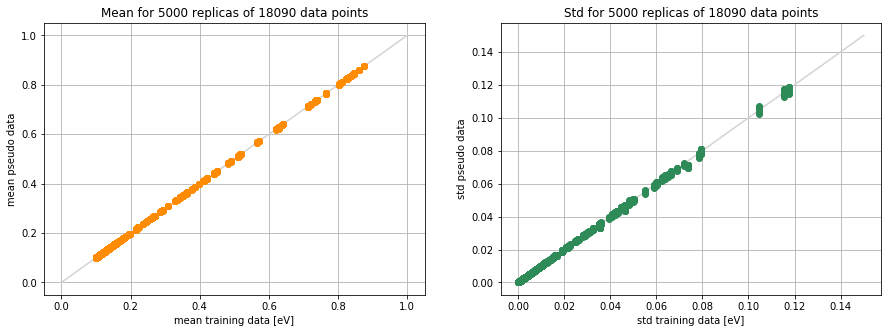

In [12]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.title('Mean for %(Nrep)s replicas of %(N_train)s data points' % {"Nrep": Nrep, "N_train": N_train})
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), color='lightgrey')
plt.plot(train_y, mean_reps, 'o', color = 'darkorange', label = 'Predictions pseudodata')
plt.grid(True)
plt.xlabel(r'mean training data [eV]')
plt.ylabel(r'mean pseudo data')

plt.subplot(122)
plt.grid(True)
plt.title('Std for %(Nrep)s replicas of %(N_train)s data points' % {"Nrep": Nrep, "N_train": N_train})
plt.plot(np.linspace(0,0.15,10), np.linspace(0,0.15,10), color='lightgrey')
plt.plot(train_sigma, std_reps, 'o', color='seagreen', label = 'Predictions pseudodata')
plt.xlabel(r'std training data [eV]')
plt.ylabel(r'std pseudo data')

plt.show()

In [17]:
chi_array = []
import time
from datetime import datetime
tic = time.time()

training_epochs = 50000
max_rising_epochs = 10000 #The amount of epochs the minimzer is allowed to overfit before it stops
display_step = 1000
%store Nrep
%store training_epochs

### Define cost and optimizer
cost = tf.reduce_mean(tf.square((y-predictions)/sigma), name="cost_function")
custom_cost = tf.reduce_mean(tf.square((y-predictions)/sigma), name="custom_cost_function")
eta = 3e-2

optimizer = tf.train.AdamOptimizer(learning_rate=eta, beta1=0.9, beta2=0.999, epsilon=1e-08).minimize(cost)

i = 0
Nrep = 30

while i < (Nrep):
    
    """Training data: train_y = D_i + rand.norm(0, sigma_i);
    use train_y = gaus_y + rand.norm(0, sigma_i) in case of Closure testing"""
    
    train_y = train_y_reps[:,i].reshape(N_train,1)
    test_y = test_y_reps[:,i].reshape(N_test,1)

    ### Train and validate
    prev_test_cost = 100
    prev_epoch=0
    avg_cost = 0.0

    array_train = []
    array_test = []
    
    print("Start training on", '%04d' %(N_train), "and validating on", '%0.4d' %(N_test), "samples")

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        

        for epoch in range(training_epochs):

            _, c = sess.run([optimizer, cost], 
                            feed_dict={
                                x: train_x,
                                y: train_y,
                                sigma: train_sigma
                            })
            avg_cost = c 

            test_cost = cost.eval({x: test_x, y: test_y, sigma: test_sigma})


            if epoch % display_step == 0:
                print("Epoch:", '%04d' % (epoch+1), "| Training cost=", "{:.9f}".format(avg_cost), "| Validation cost=", "{:.9f}".format(test_cost))
                array_train.append(avg_cost)
                array_test.append(test_cost)

            if test_cost >= prev_test_cost and epoch-prev_epoch >= max_rising_epochs:
                print(colored("\n The session stopped because of overfitting...","red"))
                print("Start overfitting at epoch:", '%04d' % (epoch), "| Validation cost =", "{:.9f}".format(test_cost), "| Train cost=", "{:.9f}".format(avg_cost))
                break

            elif test_cost < prev_test_cost:
                prev_test_cost = test_cost
                prev_epoch = epoch


        print("Optimization Finished!")
        predictions_values = sess.run(predictions, 
                            feed_dict={
                                x: train_x,
                                y: train_y 
                            })   
    
    sess.close()

    # save to csv file
    predictions_values = predictions_values.reshape(N_train,)
    toc = time.time()
    print("Elapsed time:", toc-tic)

    #foot = np.array(seednumber)
    a = np.array(train_x[:,0])
    b = np.array(train_y)
    c = np.array(predictions_values)
    d = array_train
    e = array_test
    
    chi_array.append(d[-1])

    now = datetime.now()
  
    dt_string = now.strftime("%d.%m.%Y %H:%M:%S")
    d_string = now.strftime("%d.%m.%Y")
    t_string = now.strftime("%H:%M:%S")
    
    best_chi = np.where(array_test == min(array_test))
    
    np.savetxt('Data/Results/%(date)s/xyp_all_e%(epoch)s_%(i)x.csv' % {"date": d_string, "epoch": training_epochs, "i": i }, list(zip(a,b,c)),  delimiter=',',  header="best iteration: %(p)s" % {"p": best_chi}, fmt='%f')
    np.savetxt('Data/Results/%(date)s/chi_all_e%(epoch)s_%(i)x.csv' % {"date": d_string, "epoch": training_epochs, "i": i }, list(zip(d,e)),  delimiter=',',  header="best iteration: %(p)s" % {"p": best_chi}, fmt='%f')
 
    print(i)
    i+=1

Stored 'Nrep' (int)
Stored 'training_epochs' (int)
Start training on 18090 and validating on 3181 samples
Epoch: 0001 | Training cost= 2892328.250000000 | Validation cost= 827807.562500000
Epoch: 1001 | Training cost= 22.256044388 | Validation cost= 18.658340454
Epoch: 2001 | Training cost= 19.169361115 | Validation cost= 16.156234741
Epoch: 3001 | Training cost= 18.586708069 | Validation cost= 15.678471565
Epoch: 4001 | Training cost= 18.008943558 | Validation cost= 15.203779221
Epoch: 5001 | Training cost= 19.909521103 | Validation cost= 19.647197723
Epoch: 6001 | Training cost= 35.564315796 | Validation cost= 55.142627716
Epoch: 7001 | Training cost= 15.519657135 | Validation cost= 13.179031372
Epoch: 8001 | Training cost= 14.513394356 | Validation cost= 12.639668465
Epoch: 9001 | Training cost= 13.265795708 | Validation cost= 11.836851120
Epoch: 10001 | Training cost= 12.168477058 | Validation cost= 10.928151131
Epoch: 11001 | Training cost= 10.825281143 | Validation cost= 9.857781

Epoch: 14001 | Training cost= 1.715619445 | Validation cost= 1.342065930
Epoch: 15001 | Training cost= 37.042716980 | Validation cost= 7.584545135
Epoch: 16001 | Training cost= 1.635538101 | Validation cost= 1.337216139
Epoch: 17001 | Training cost= 2.763240099 | Validation cost= 2.737440109
Epoch: 18001 | Training cost= 1.747971892 | Validation cost= 3.569325924
Epoch: 19001 | Training cost= 1.362325907 | Validation cost= 1.254162669
Epoch: 20001 | Training cost= 1.463806868 | Validation cost= 1.262458324
Epoch: 21001 | Training cost= 1.233709097 | Validation cost= 1.278318286
Epoch: 22001 | Training cost= 1.140463471 | Validation cost= 1.135576129
Epoch: 23001 | Training cost= 1.128885865 | Validation cost= 1.129325390
Epoch: 24001 | Training cost= 1.157903552 | Validation cost= 1.141243935
Epoch: 25001 | Training cost= 1.114089370 | Validation cost= 1.118672132
Epoch: 26001 | Training cost= 1.106992006 | Validation cost= 1.107146621
Epoch: 27001 | Training cost= 68.853439331 | Valid

Epoch: 23001 | Training cost= 1.661124587 | Validation cost= 1.286325693
Epoch: 24001 | Training cost= 1.633304000 | Validation cost= 1.273668408
Epoch: 25001 | Training cost= 9.993596077 | Validation cost= 5.934331894
Epoch: 26001 | Training cost= 1.180765867 | Validation cost= 1.187137485
Epoch: 27001 | Training cost= 19.743825912 | Validation cost= 10.472456932
Epoch: 28001 | Training cost= 1.109898448 | Validation cost= 1.145717502
Epoch: 29001 | Training cost= 4.103869915 | Validation cost= 6.188291550
Epoch: 30001 | Training cost= 1.725543737 | Validation cost= 1.335036516
Epoch: 31001 | Training cost= 1.101979852 | Validation cost= 1.130468607
Epoch: 32001 | Training cost= 3.602458239 | Validation cost= 3.262553215
Epoch: 33001 | Training cost= 1.387687206 | Validation cost= 1.438719511
Epoch: 34001 | Training cost= 1.086004257 | Validation cost= 1.113677740
Epoch: 35001 | Training cost= 1.715218425 | Validation cost= 1.317322969
Epoch: 36001 | Training cost= 59.923252106 | Vali

Epoch: 43001 | Training cost= 1.098553300 | Validation cost= 1.103817701
Epoch: 44001 | Training cost= 1.097688794 | Validation cost= 1.103007793
Epoch: 45001 | Training cost= 1.213764787 | Validation cost= 1.210186839
Epoch: 46001 | Training cost= 1.137998343 | Validation cost= 1.133244991
Epoch: 47001 | Training cost= 1.119372487 | Validation cost= 1.111247301
Epoch: 48001 | Training cost= 1.134352326 | Validation cost= 1.125826478
Epoch: 49001 | Training cost= 1.110841751 | Validation cost= 1.107306600
Optimization Finished!
Elapsed time: 1881.0858931541443
6
Start training on 18090 and validating on 3181 samples
Epoch: 0001 | Training cost= 6157.485351562 | Validation cost= 694037.000000000
Epoch: 1001 | Training cost= 19.067848206 | Validation cost= 16.245672226
Epoch: 2001 | Training cost= 18.176347733 | Validation cost= 15.461095810
Epoch: 3001 | Training cost= 16.945476532 | Validation cost= 14.549304962
Epoch: 4001 | Training cost= 14.888092995 | Validation cost= 13.019489288


Epoch: 7001 | Training cost= 18.860418320 | Validation cost= 16.030056000
Epoch: 8001 | Training cost= 17.693906784 | Validation cost= 15.146707535
Epoch: 9001 | Training cost= 17.438518524 | Validation cost= 14.914516449
Epoch: 10001 | Training cost= 18.377672195 | Validation cost= 18.355136871
Epoch: 11001 | Training cost= 14.331545830 | Validation cost= 12.491351128
Epoch: 12001 | Training cost= 12.420791626 | Validation cost= 11.165805817
Epoch: 13001 | Training cost= 13.540182114 | Validation cost= 12.887125015
Epoch: 14001 | Training cost= 10.854159355 | Validation cost= 9.953076363
Epoch: 15001 | Training cost= 13.427089691 | Validation cost= 12.902380943
Epoch: 16001 | Training cost= 7.456265450 | Validation cost= 7.083378792
Epoch: 17001 | Training cost= 5.205957890 | Validation cost= 5.270222664
Epoch: 18001 | Training cost= 3.743023634 | Validation cost= 4.043094158
Epoch: 19001 | Training cost= 10.108849525 | Validation cost= 9.296918869
Epoch: 20001 | Training cost= 3.4658

Epoch: 15001 | Training cost= 1.752870679 | Validation cost= 1.336168408
Epoch: 16001 | Training cost= 1.673563004 | Validation cost= 1.272680521
Epoch: 17001 | Training cost= 1.836603284 | Validation cost= 1.274686456
Epoch: 18001 | Training cost= 1.613357663 | Validation cost= 1.258979917
Epoch: 19001 | Training cost= 1.490161300 | Validation cost= 1.225871086
Epoch: 20001 | Training cost= 1.719605803 | Validation cost= 1.854738593
Epoch: 21001 | Training cost= 1.207657576 | Validation cost= 1.134581566
Epoch: 22001 | Training cost= 6.834954739 | Validation cost= 4.591709614
Epoch: 23001 | Training cost= 1.150196552 | Validation cost= 1.109055161
Epoch: 24001 | Training cost= 1.143743515 | Validation cost= 1.108249903
Epoch: 25001 | Training cost= 1.152700305 | Validation cost= 1.106482863
Epoch: 26001 | Training cost= 1.115281463 | Validation cost= 1.101925731
Epoch: 27001 | Training cost= 1.110989213 | Validation cost= 1.102765203
Epoch: 28001 | Training cost= 1.128883958 | Validat

Epoch: 24001 | Training cost= 1.492800713 | Validation cost= 1.235953331
Epoch: 25001 | Training cost= 1.238288164 | Validation cost= 1.179539919
Epoch: 26001 | Training cost= 1.147300839 | Validation cost= 1.149644136
Epoch: 27001 | Training cost= 1.107606649 | Validation cost= 1.120262980
Epoch: 28001 | Training cost= 1.583275080 | Validation cost= 1.373345017
Epoch: 29001 | Training cost= 1.089145899 | Validation cost= 1.110884190
Epoch: 30001 | Training cost= 1.095777512 | Validation cost= 1.113505960
Epoch: 31001 | Training cost= 101.872459412 | Validation cost= 53.650714874
Epoch: 32001 | Training cost= 1.082932949 | Validation cost= 1.109144211
Epoch: 33001 | Training cost= 1.414122820 | Validation cost= 1.123156071
Epoch: 34001 | Training cost= 1.079553843 | Validation cost= 1.106257915
Epoch: 35001 | Training cost= 3.747881174 | Validation cost= 1.531653047
Epoch: 36001 | Training cost= 1.078803301 | Validation cost= 1.105242014
Epoch: 37001 | Training cost= 1.148566365 | Vali

Epoch: 35001 | Training cost= 1.081514359 | Validation cost= 1.068351150
Epoch: 36001 | Training cost= 1.082461357 | Validation cost= 1.078301787
Epoch: 37001 | Training cost= 1.161138177 | Validation cost= 1.296021342
Epoch: 38001 | Training cost= 149.536071777 | Validation cost= 91.503654480
Epoch: 39001 | Training cost= 1.081679583 | Validation cost= 1.072134972
Epoch: 40001 | Training cost= 1.080254793 | Validation cost= 1.071018100
Epoch: 41001 | Training cost= 1.079944849 | Validation cost= 1.070592523
Epoch: 42001 | Training cost= 1.079876065 | Validation cost= 1.070420384
Epoch: 43001 | Training cost= 1.086342216 | Validation cost= 1.078921199

 The session stopped because of overfitting...
Start overfitting at epoch: 43592 | Validation cost = 1.070411682 | Train cost= 1.084732533
Optimization Finished!
Elapsed time: 4411.787962198257
15
Start training on 18090 and validating on 3181 samples
Epoch: 0001 | Training cost= 5136501.000000000 | Validation cost= 2906898.000000000
Epo

Epoch: 48001 | Training cost= 1.107175469 | Validation cost= 1.180796742

 The session stopped because of overfitting...
Start overfitting at epoch: 48144 | Validation cost = 1.126819491 | Train cost= 1.089515924
Optimization Finished!
Elapsed time: 5001.279498100281
17
Start training on 18090 and validating on 3181 samples
Epoch: 0001 | Training cost= 4844854.000000000 | Validation cost= 1611041.750000000
Epoch: 1001 | Training cost= 26.509460449 | Validation cost= 22.917636871
Epoch: 2001 | Training cost= 22.736331940 | Validation cost= 19.610153198
Epoch: 3001 | Training cost= 19.532901764 | Validation cost= 16.876705170
Epoch: 4001 | Training cost= 18.557209015 | Validation cost= 15.964054108
Epoch: 5001 | Training cost= 18.293769836 | Validation cost= 15.808593750
Epoch: 6001 | Training cost= 18.208211899 | Validation cost= 17.291969299
Epoch: 7001 | Training cost= 16.015230179 | Validation cost= 13.948331833
Epoch: 8001 | Training cost= 14.749280930 | Validation cost= 12.94394779

Epoch: 4001 | Training cost= 15.701990128 | Validation cost= 13.380068779
Epoch: 5001 | Training cost= 16.080526352 | Validation cost= 13.761081696
Epoch: 6001 | Training cost= 14.247392654 | Validation cost= 12.338722229
Epoch: 7001 | Training cost= 13.499079704 | Validation cost= 11.793667793
Epoch: 8001 | Training cost= 12.690983772 | Validation cost= 11.133518219
Epoch: 9001 | Training cost= 12.074056625 | Validation cost= 10.643198967
Epoch: 10001 | Training cost= 13.004309654 | Validation cost= 11.082372665
Epoch: 11001 | Training cost= 10.514889717 | Validation cost= 9.397358894
Epoch: 12001 | Training cost= 20.977249146 | Validation cost= 15.851943016
Epoch: 13001 | Training cost= 8.658855438 | Validation cost= 7.839207649
Epoch: 14001 | Training cost= 6.368716240 | Validation cost= 5.884912968
Epoch: 15001 | Training cost= 4.076779366 | Validation cost= 3.935233355
Epoch: 16001 | Training cost= 2.735983610 | Validation cost= 2.531178236
Epoch: 17001 | Training cost= 2.37314939

Epoch: 13001 | Training cost= 8.296496391 | Validation cost= 6.427677155
Epoch: 14001 | Training cost= 2.500660181 | Validation cost= 2.088916063
Epoch: 15001 | Training cost= 1.951324105 | Validation cost= 1.592732549
Epoch: 16001 | Training cost= 3.670009851 | Validation cost= 2.591513634
Epoch: 17001 | Training cost= 6.526648998 | Validation cost= 13.537675858
Epoch: 18001 | Training cost= 1.601942539 | Validation cost= 1.297166467
Epoch: 19001 | Training cost= 1.542391300 | Validation cost= 1.283039570
Epoch: 20001 | Training cost= 1.407659888 | Validation cost= 1.300974607
Epoch: 21001 | Training cost= 1.188872933 | Validation cost= 1.168999076
Epoch: 22001 | Training cost= 1.229009628 | Validation cost= 1.213863015
Epoch: 23001 | Training cost= 2.911229849 | Validation cost= 6.014785767
Epoch: 24001 | Training cost= 1.244504213 | Validation cost= 1.213799477
Epoch: 25001 | Training cost= 1.094779968 | Validation cost= 1.107204676
Epoch: 26001 | Training cost= 1.090371132 | Valida

Epoch: 22001 | Training cost= 1.767507076 | Validation cost= 1.945231557
Epoch: 23001 | Training cost= 1.473623633 | Validation cost= 1.480859399
Epoch: 24001 | Training cost= 1.195247054 | Validation cost= 1.154274821
Epoch: 25001 | Training cost= 1.232231259 | Validation cost= 1.191276908
Epoch: 26001 | Training cost= 1.154810190 | Validation cost= 1.130938530
Epoch: 27001 | Training cost= 1.371196032 | Validation cost= 1.196147561
Epoch: 28001 | Training cost= 1.132712841 | Validation cost= 1.119609952
Epoch: 29001 | Training cost= 1.123666525 | Validation cost= 1.120329380
Epoch: 30001 | Training cost= 1.117499948 | Validation cost= 1.114781976
Epoch: 31001 | Training cost= 1.112448931 | Validation cost= 1.111092687
Epoch: 32001 | Training cost= 1.108579636 | Validation cost= 1.108730316
Epoch: 33001 | Training cost= 1.106164336 | Validation cost= 1.106571436
Epoch: 34001 | Training cost= 1.104806662 | Validation cost= 1.106528759
Epoch: 35001 | Training cost= 1.102198005 | Validat

Epoch: 30001 | Training cost= 1.166322231 | Validation cost= 1.218031883
Epoch: 31001 | Training cost= 1.407558560 | Validation cost= 1.194164991
Epoch: 32001 | Training cost= 1.386750698 | Validation cost= 1.604432344
Epoch: 33001 | Training cost= 43.268371582 | Validation cost= 42.444946289
Epoch: 34001 | Training cost= 1.083462715 | Validation cost= 1.086974382
Epoch: 35001 | Training cost= 1.074860930 | Validation cost= 1.080512643
Epoch: 36001 | Training cost= 1.364455819 | Validation cost= 1.596612930
Epoch: 37001 | Training cost= 1.139237761 | Validation cost= 1.116243243
Epoch: 38001 | Training cost= 1.506734133 | Validation cost= 1.215754271
Epoch: 39001 | Training cost= 1.066300869 | Validation cost= 1.070288301
Epoch: 40001 | Training cost= 2.727894068 | Validation cost= 2.767575979
Epoch: 41001 | Training cost= 1.067476630 | Validation cost= 1.075371027
Epoch: 42001 | Training cost= 1.063385606 | Validation cost= 1.066722274
Epoch: 43001 | Training cost= 1.062530279 | Valid

Epoch: 45001 | Training cost= 1.083695292 | Validation cost= 1.086996436
Epoch: 46001 | Training cost= 20.986454010 | Validation cost= 12.252243996
Epoch: 47001 | Training cost= 1.081505656 | Validation cost= 1.085952044
Epoch: 48001 | Training cost= 1.081221938 | Validation cost= 1.085143566
Epoch: 49001 | Training cost= 1.080185175 | Validation cost= 1.085476637
Optimization Finished!
Elapsed time: 8036.576233148575
28
Start training on 18090 and validating on 3181 samples
Epoch: 0001 | Training cost= 95896.242187500 | Validation cost= 420441.781250000
Epoch: 1001 | Training cost= 18.848785400 | Validation cost= 16.380428314
Epoch: 2001 | Training cost= 18.474550247 | Validation cost= 16.071702957
Epoch: 3001 | Training cost= 18.541584015 | Validation cost= 16.136384964
Epoch: 4001 | Training cost= 18.431459427 | Validation cost= 16.062797546
Epoch: 5001 | Training cost= 16.946971893 | Validation cost= 14.784051895
Epoch: 6001 | Training cost= 13.550966263 | Validation cost= 12.24707

### Plot outputs

In [87]:
np.savetxt('Data/Results/%(now)s/train_time.csv' % {"now": d_string} ,train_x[:,1])
np.savetxt('Data/Results/%(now)s/train_energy.csv' % {"now": d_string}, train_x[:,2])

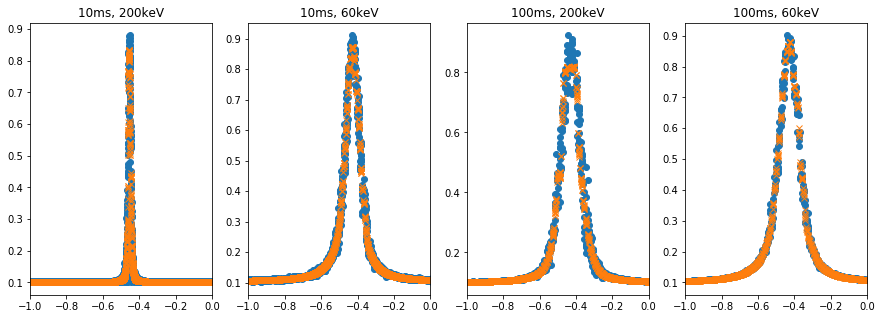

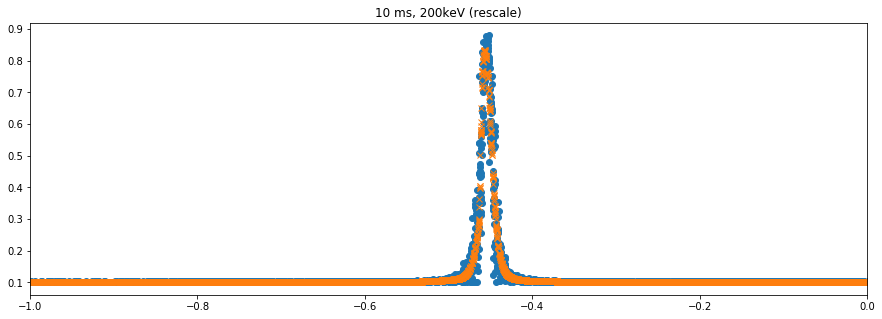

In [18]:
plt.figure(figsize=(15,5))

index10200 = np.where((train_x[:,1] == .1) & (train_x[:,2] == 2))
index1060 = np.where((train_x[:,1] == .1) & (train_x[:,2] == .6))
index100200 = np.where((train_x[:,1] == 1) & (train_x[:,2] == 2))
index10060 = np.where((train_x[:,1] == 1) & (train_x[:,2] == .6))

plt.subplot(141)
plt.title('10ms, 200keV')
plt.xlim([-1,0])
plt.plot(train_x[index10200,0].T, train_y[index10200],'o')
plt.plot(train_x[index10200,0].T, predictions_values[index10200], 'x')
#plt.plot(train_x[index10200,0].T, train_y[index10200],'o')

plt.subplot(142)
plt.xlim([-1,0])
plt.title('10ms, 60keV')
plt.plot(train_x[index1060,0].T, train_y[index1060],'o')
plt.plot(train_x[index1060,0].T, predictions_values[index1060], 'x')

plt.subplot(143)
plt.xlim([-1,0])
plt.title('100ms, 200keV')
plt.plot(train_x[index100200,0].T, train_y[index100200],'o')
plt.plot(train_x[index100200,0].T, predictions_values[index100200], 'x')

plt.subplot(144)
plt.xlim([-1,0])
plt.title('100ms, 60keV')
plt.plot(train_x[index10060,0].T, train_y[index10060],'o')
plt.plot(train_x[index10060,0].T, predictions_values[index10060], 'x')

plt.show()

plt.figure(figsize=(15,5))
plt.title('10 ms, 200keV (rescale)')
plt.xlim([-1,0])
plt.plot(train_x[index10200,0].T, train_y[index10200],'o')
plt.plot(train_x[index10200,0].T, predictions_values[index10200], 'x')
plt.show()


Below, the distribution of $\chi^2$ is plotted for training over the $N_{rep}$ MC replicas.

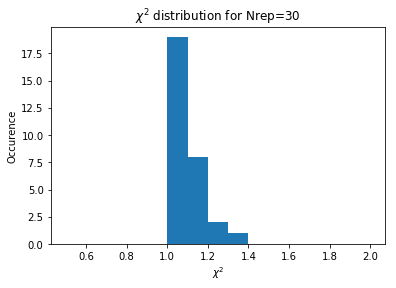

In [86]:
%run Evaluate_pseudodata.ipynb
Nrep=30
plt.hist(chi2_array, bins=15, range=[0.5, 2])
plt.title('$\chi^2$ distribution for Nrep=30')
plt.xlabel('$\chi^2$')
plt.ylabel('Occurence')
plt.savefig('Data/Results/%(date)s/aaa chidistribution_%(epoch)s_Nrep=%(i)s' % {"date": d_string, "epoch": training_epochs, "i": Nrep })

plt.show()


## Residuals

In [81]:
best_pred = pseudo_pred[0:N_train]
best_y = pseudo_y[0:N_train]
train_sigma = train_sigma.reshape(N_train,)
best_res = residuals(best_pred, best_y, train_sigma)

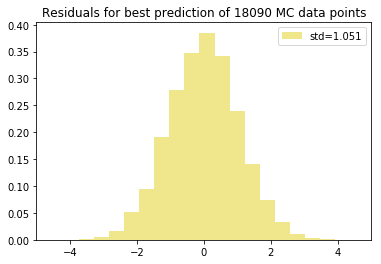

In [88]:
n, bins = np.histogram(best_res, bins=20)

mids = 0.5*(bins[1:] + bins[:-1])
probs = n / np.sum(n)

mean = np.sum(probs * mids)  
sd = np.sqrt(np.sum(probs * (mids - mean)**2))

label1 = 'std=%(std).5s' % {"std":sd}

fig = plt.hist(best_res, bins=20, density=True, color='khaki', label=label1)
plt.title('Residuals for best prediction of %(N_train)s MC data points' % {"N_train": N_train})
plt.legend([label1])

plt.xlim([-5, 5])
plt.show()

## Write everything to report file

In [ ]:
import sys
import base64

energy = 200
time = 10
nbins = 60
training_epochs = 100000

reportname = r'Reports/%(date)s_%(energy)skeV_%(time)sms_e%(epoch)s_Nrep=%(i)s.html' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }
sys.stdout = open(reportname,'w')


from prettytable import PrettyTable
list1 = ['Energy:','Exposure time:','Nbins:', 'Replicas:', 'Training epochs:']
list2 = [energy, time, nbins, Nrep, training_epochs]

for x in range(0,5):
    print('%(s1)s %(s2)s <br />' % {"s1": list1[x], "s2": list2[x]}) 


In [ ]:
plot1 = r'Data/Results/%(date)s/aaa chidistribution_%(energy)s_%(time)sms_e%(epoch)s_Nrep=%(i)s.png' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }
plot2 = r'Data/Results/%(date)s/aaa means-vs-means_%(energy)s_%(time)sms_e%(epoch)s_Nrep=%(i)s.png' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }
plot3 = r'Data/Results/%(date)s/aaa std-vs-std_%(energy)s_%(time)sms_e%(epoch)s_Nrep=%(i)s.png' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }
plot4 = r'Data/Results/%(date)s/aaa Residuals_%(energy)s_%(time)sms_e%(epoch)s_Nrep=%(i)s.png' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }

data_uri1 = base64.b64encode(open(plot1, 'rb').read()).decode('utf-8')
data_uri2 = base64.b64encode(open(plot2, 'rb').read()).decode('utf-8')
data_uri3 = base64.b64encode(open(plot3, 'rb').read()).decode('utf-8')
data_uri4 = base64.b64encode(open(plot4, 'rb').read()).decode('utf-8')
img_tag1 = '<img src="data:image/png;base64,{0}">'.format(data_uri1)
img_tag2 = '<img src="data:image/png;base64,{0}">'.format(data_uri2)
img_tag3 = '<img src="data:image/png;base64,{0}">'.format(data_uri3)
img_tag4 = '<img src="data:image/png;base64,{0}">'.format(data_uri4)

print(img_tag1)
print(img_tag2)
print(img_tag3)
print(img_tag4)